In [1]:
# Ethan Vaz Falcao 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import seaborn as seabornInstance
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from scipy.stats import poisson

In [2]:
df = pd.read_csv("/Users/Ethan Vaz Falcao/Downloads/Data/Fifa_world_cup.csv", sep=",")
df=df.drop(["Unnamed: 0"], axis = 1)

In [3]:
df

,date,home_team,away_team,home_team_score,away_team_score,tournament,location,home_team_total_fifa_points,home_team_fifa_rank,away_team_total_fifa_points,away_team_fifa_rank,goal_difference,goal_total
0,2008-08-01,Afghanistan,Turkmenistan,0,5,AFC Challenge Cup,Hyderabad,53.00,181.0,127.00,158.0,5,5
1,2008-08-01,India,Tajikistan,1,1,AFC Challenge Cup,Hyderabad,137.00,153.0,135.00,154.0,0,2
2,2008-08-02,Sri Lanka,Myanmar,1,3,AFC Challenge Cup,Hyderabad,111.00,161.0,100.00,164.0,2,4
3,2008-08-03,Afghanistan,Tajikistan,0,4,AFC Challenge Cup,Hyderabad,53.00,181.0,135.00,154.0,4,4
4,2008-08-03,India,Turkmenistan,2,1,AFC Challenge Cup,Hyderabad,137.00,153.0,127.00,158.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,2022-09-27,Norway,Serbia,0,2,UEFA Nations League,Oslo,1488.57,36.0,1549.53,25.0,2,2
10944,2022-09-27,Sweden,Slovenia,1,1,UEFA Nations League,Stockholm,1563.44,20.0,1372.48,65.0,0,2
10945,2022-09-27,Kosovo,Cyprus,5,1,UEFA Nations League,Pristina,1183.90,106.0,1180.52,108.0,4,6
10946,2022-09-27,Greece,Northern Ireland,3,1,UEFA Nations League,Athens,1441.45,49.0,1399.10,58.0,2,4


In [4]:
mean_goals = sum(df["home_team_score"])/(len(df))
print(mean_goals)
mean_goals_dF = sum(df["away_team_score"])/(len(df))
print(mean_goals_dF)

1.5448483741322616
1.0533430763609792


In [5]:
df_home = df[['home_team', "home_team_fifa_rank","home_team_score","away_team_score"]]
df_away = df[['away_team', "away_team_fifa_rank","home_team_score","away_team_score"]]

df_home = df_home.rename(columns={'home_team': "Team", "home_team_fifa_rank":"fifa_rank","home_team_score":"Goals","away_team_score":"Goals_Conceded"})
df_away = df_away.rename(columns={'away_team': "Team", "away_team_fifa_rank":"fifa_rank","home_team_score": "Goals_Conceded","away_team_score":"Goals"})

df_team = pd.concat([df_home,df_away],ignore_index= True).groupby("Team").mean()


Calculating Offense Strength is dividing the team’s average number of goals scored by the average number of goals allowed. Calculating Defence Strength is dividing the team’s average number of goals allowed by the average number of goals allowed.

In [6]:
df_team["Of_strength"]= df_team["Goals"]/mean_goals
df_team["Df_strength"]= df_team["Goals_Conceded"]/mean_goals_dF
df_team

,fifa_rank,Goals,Goals_Conceded,Of_strength,Df_strength
Team,,,,,
Afghanistan,156.062500,1.262500,1.600000,0.817232,1.518973
Albania,63.333333,1.029630,1.133333,0.666492,1.075939
Algeria,38.448276,1.786207,0.882759,1.156234,0.838054
American Samoa,199.600000,1.133333,4.200000,0.733621,3.987305
Andorra,174.450450,0.324324,2.369369,0.209939,2.249380
...,...,...,...,...,...
Vietnam,125.410714,1.589286,1.232143,1.028765,1.169745
Wales,38.308271,1.112782,1.120301,0.720318,1.063567
Yemen,148.029703,0.712871,1.752475,0.461451,1.663727


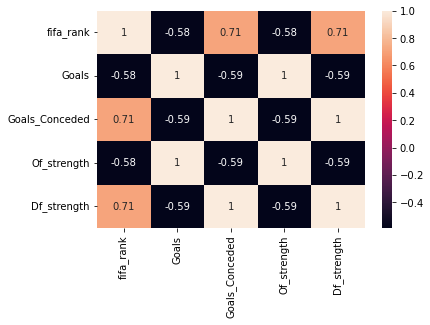

In [7]:
ax = sns.heatmap(df_team.corr(), annot=True)
#plt.show()
def goals_prob(home, away):
    goals_exp_home = df_team["Of_strength"][home] * df_team["Df_strength"][away]
    goals_exp_away = df_team["Of_strength"][away] * df_team["Df_strength"][home]
    return goals_exp_home, goals_exp_away

In [8]:
#Uses a Poisson distribution to calculate the expected score of a football match between two contries 
def match_score(home,away):
    if home in df_team.index and away in df_team.index:
        exp_home =df_team["Of_strength"][home]*df_team["Df_strength"][away]
        exp_away =df_team["Of_strength"][away]*df_team["Df_strength"][home]
       # return goals_exp_home,goals_exp_away
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, exp_home) * poisson.pmf(y, exp_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        print(points_home, points_away)
        if(points_home>points_away):
            print(home," is likely to win!")
        else:
            print(away," is likely to win!")
    else:
        return (0, 0)

In [9]:
match_score("France","Argentina") 

1.3678486571292472 1.3145081016173175
France  is likely to win!


In [10]:
match_score("Croatia","Morocco") 

1.1355905079153732 1.5378927697752605
Morocco  is likely to win!


In [11]:
#LinearRegression
x = pd.DataFrame(df[['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points']])
x_train, x_test, y_train, y_test = train_test_split(x, df['home_team_score'] - df['away_team_score'], test_size=0.2, random_state=2)
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)
y_pred = reg.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print("MSE Linear Regression:", mse)
print("Coef Linear:", reg.coef_)


MSE Linear Regression: 3.1262974952963543
Coef Linear: [-0.01878278  0.0201612   0.00027971 -0.00038169]


In [12]:
#KNeighborsRegressor n=5   
reg2 = KNeighborsRegressor(n_neighbors=5)
reg2.fit(x_train,y_train)
y_pred2 = reg2.predict(x_test)
mse2 = mean_squared_error(y_test,y_pred2)
print("MSE KNN = 5:", mse2)

MSE KNN = 5: 3.663744292237443


In [13]:
#KNeighborsRegressor n=10
reg3 = KNeighborsRegressor(n_neighbors=10)
reg3.fit(x_train,y_train)
y_pred3 = reg3.predict(x_test)
mse3 = mean_squared_error(y_test,y_pred3)
print("MSE KNN = 10:", mse3)

MSE KNN = 10: 3.3772420091324205


In [14]:
#Linear Discriminant Analysis
reg4 = LinearDiscriminantAnalysis()
reg4.fit(x_train,y_train)
y_pred4 = reg4.predict(x_test)
mse4 = mean_squared_error(y_test, y_pred4)
print("MSE LDA:", mse4)

MSE LDA: 3.6744292237442924


In [15]:
#LASSO cross-validation
model = LassoCV()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print("Test ErrorLasso: " + str(mean_squared_error(y_test, predictions)))
print("Coefficients: ", str(len(model.coef_)))


Test ErrorLasso: 3.1276527272157084
Coefficients:  4


In [16]:
#Ridge cross-validation
model = RidgeCV()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print("Test ErrorRidge: " + str(mean_squared_error(y_test, predictions)))
print("Coefficients: ", str(len(model.coef_)))

Test ErrorRidge: 3.12629766278628
Coefficients:  4
